### This Supplementary material gives an implementation of Sequential Pitch Distributions (SPD) which is the core concept of the paper
We have used a pitch file which is also added as part of Supplement, This file is of Raga Purya Dhanasri which was requested from CompMusic
This file has an mbid: 930ae825-111c-4dd5-b8be-de609fd5202d and tonic frequency of 212.874556 Hz

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
file_name = '930ae825-111c-4dd5-b8be-de609fd5202d.tsv'
file_tonic = 212.874556

### Function to get pitch data

In [3]:
def get_pitch_data(pitch_file_path):
    data = pd.read_csv(pitch_file_path, sep='\t')
    return data

### Convert pitch frequency to an array of 60 pitch values with gaussian smooth with standard deviation 25

In [4]:
def freq_to_cents(freq, std=25):
    frequency_reference = 10
    c_true = 1200 * math.log((freq+1e-6) / frequency_reference, 2)

    cents_mapping = np.linspace(0, 7180, 360) + 1997.3794084376191
    target = np.exp(-(cents_mapping - c_true) ** 2 / (2 * std ** 2))

    return np.sum(target.reshape([6, 60]), 0)


### Function to convert all pitche frequency to pitch value array

In [5]:
def get_pitchvalues(pitches):
    pitches_arr = pitches.values[:,0]
    pitchvalue_prob = []
    for idx, p in enumerate(pitches_arr):
        if p==0:
            continue
        pitchvalue_prob.append(freq_to_cents(p))
    return np.array(pitchvalue_prob)

### Function to re-order the pitchvalue porbability array based on tonic

In [6]:
def reorder_tonic(pitchvalue_prob, tonic_freq):
    tonic_pv_arr = freq_to_cents(tonic_freq)
    tonic_pv = np.argmax(tonic_pv_arr) 
    return np.roll(pitchvalue_prob, -tonic_pv, axis=1)

### Function to normalize

In [7]:
def normalize(z):
    z_min = np.min(z)
    return (z - z_min)/(np.max(z)-z_min+0.001)

### Saw tooth wave with a period of 60
    This is defined in Equation 1, Page 3 in the paper

In [8]:
def modulo(x):
    return x%60

### Modulo Add
We define another function n which adds 60 to the modulo function
whenever x is greater than y
This function is defined in Equation 2; Page 3

In [9]:
def modulo_add(x,y):
    mx = modulo(x)
    my = modulo(y)
    if mx>my:
        return my+60
    return my

### Relax
Function to relax a pitch value by +/- 2 pitch values (+/- 40 cents).

This is defined in Equations 3-6; Page 3

In [10]:
def relax_fun(p,add,r=2):
    if add:
        return modulo(p+2)
    return modulo(p-2)

### Compare
We define function compare that evaluates to 1 when 'x' is at an equal or
higher pitch than 'a' and at an equal or at a lower pitch than
'b', else it evaluates to 0


This function is defined in Equation 7; Page 4

For the descending case refer line 268, 269 in the paper

In [11]:
def compare(a,b,x,asc):
    if not asc:
        a, b = b, a
    if a <= modulo_add(a,x) <= modulo_add(a,b):
        return 1
    return 0


### Get Pitch Distribution
This function takes the mean across the time axis and normalizes

This is defined in Equation 9; Page 4

In [12]:
def get_pitch_distribution(pitchvalue_prob):
    s_mean = normalize(np.mean(pitchvalue_prob, axis=0))
    return s_mean

### Get Mean (Pitch distribution) and Standard Deviation across time axis
This is deined in equation 10; Page 4

In [13]:
def get_pitch_histograms(pitchvalue_prob):
    s_mean = get_pitch_distribution(pitchvalue_prob)
    s_std = normalize(np.std(pitchvalue_prob, axis=0))

    s = np.stack([s_mean, s_std], axis=-1)
    return s


### Get pitch distribution between start and end pitch values
This is defined in Equation 11; Page 4

In [14]:
def get_pd_between_pspe(pitchvalue_prob, ps, pe, asc, relax=2):
    if asc:
        relax_sign = relax
    else:
        relax_sign = -relax
    pd = get_pitch_distribution(pitchvalue_prob)
    w = np.zeros(60)
    for i in range(60):
        w[i] = pd[i]*compare(ps-relax_sign,pe+relax_sign,i, asc)
    return normalize(w)

### Function to compute Sequential Pitch Distributions
The below functions compute SPD for a given start pitch value (ps) and end pitch value (pe)

In [15]:
def compute_spd_ps_pe(pitchvalue_prob, ps, pe, asc, relax=2):
    default_hist = get_pd_between_pspe(pitchvalue_prob, ps, pe, asc)  # Default values to be filled when SPD is not available; line 254, 255 in the paper
    lim = 55
    pitches_arg = np.argmax(pitchvalue_prob,1) # pitch value with the highest probability
    
    if asc:
        relax_sign = relax
    else:
        relax_sign = -relax
    prev_dist = np.zeros(60)
    cum_pitch_dist = np.zeros(60)
    n = len(pitches_arg)
    k=0
    start = False
    end = False
    for idx in range(n):
        p = pitches_arg[idx]
        
        
        if compare(ps-relax_sign, ps+relax_sign, p, asc):
            start = True  # This verifies Equation 12; Page 4
        
        if start and compare(pe-relax_sign, pe+relax_sign, p, asc):
            end = True  # This verifies Equation 14; Page 4
            k=1
        
        if start and (compare(ps-relax_sign, pe+relax_sign, p, asc)): # This verifies Equation 15; Page 4
            prev_dist[p] = prev_dist[p] + 1  # Equation 16; Page 4
            k=1
        
        if start and end and not (compare(ps-relax_sign, pe+relax_sign, p, asc)):
            # This verfies Equation 13; Page 4
            cum_pitch_dist = cum_pitch_dist + prev_dist
            prev_dist = np.zeros(60)
            start = False
            end = False
            k=0
        if not (compare(ps-relax_sign, pe+relax_sign, p, asc)):
            prev_dist = np.zeros(60)
            start = False
            end = False
            k=0
    
    if k==1:
        # This handles an edge case where prev_dist is not empty but not yet been added to cum_pitch_dist
        cum_pitch_dist = cum_pitch_dist + prev_dist
    
    if np.sum(cum_pitch_dist)==0:
        return normalize(default_hist)  # Return simple pitch distributin incase SPD is empty lines 254, 255
    return normalize(cum_pitch_dist)

### Get pitch data

In [16]:
pitches = get_pitch_data(file_name)
print(pitches.shape)

(167664, 1)


### Convert to Pitch Values

In [17]:
pitchvalue_prob = get_pitchvalues(pitches)

### Reorder pitch value array for the given tonic

In [18]:
pitchvalue_prob = reorder_tonic(pitchvalue_prob, file_tonic)

### Utils to Gaussian smooth

In [19]:
def get_all_smooth_pitch_values(std=25):
    c_note = freq_to_cents(31.7 * 2, std)
    all_notes = np.zeros([60, 60])
    for p in range(60):
        all_notes[p] = get_smooth_pitch_value(c_note, p)

    return all_notes, c_note

def get_smooth_pitch_value(c_note, note):
    return np.roll(c_note, note, axis=-1)

def gauss_smooth(raga_feat):
    all_notes, c_note = get_all_smooth_pitch_values(std=25)
    smooth = np.zeros([12,12,60,2])
    for i in range(12):
        for j in range(12):
            if i==j:
                continue
            for k in range(0,2):
                smooth[i,j,:,k] = gauss_smooth_util(raga_feat[i,j,:,k], all_notes)
    return smooth
                
def gauss_smooth_util(arr1, all_notes):
    smooth = 0
    for i in range(60):
        smooth = smooth + all_notes[i]*arr1[i]
    
#     smooth = np.power(normalize(smooth), 0.8)
    smooth = normalize(smooth)
    return smooth

### Generate full SPD (All ps, pe pairs and both ascending and descending)

In [20]:
def full_spd(pitchvalue_prob):
    lim = 55
    spd_array = np.zeros([12,12,60,2])
    
    for i in range(0, 60, 5):
        for j in range(0, lim + 1, 5):
            s = i
            e = j
            if s==e:
                continue
            spd_asc = compute_spd_ps_pe(pitchvalue_prob, s, e, asc=True)
            spd_dsc = compute_spd_ps_pe(pitchvalue_prob, e, s, asc=False)
            
            spd_array[i//5, j//5, :, 0] = spd_asc
            spd_array[i//5, j//5, :, 1] = spd_dsc
                    
    return spd_array
    

### Generate full SPD and Smooth

In [21]:
spd_array = full_spd(pitchvalue_prob)  # Can take several minutes
spd_array = gauss_smooth(spd_array)

## Examples

SPD for a transition of notes from Ma' (30) to Ni (55) in an ascending order; As shown in Figure 1 (Blue) Top left in the paper

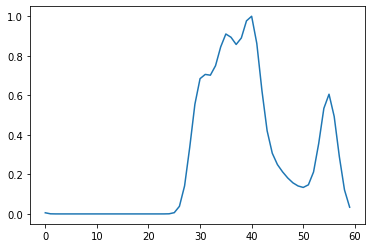

In [22]:
plt.plot(spd_array[6,11,:,0])

SPD for a transition of notes from Ni (55) to Ma' (30) in a descending order; As shown in Figure 1 (Blue) Top Middle in the paper

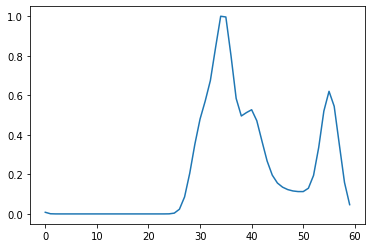

In [23]:
plt.plot(spd_array[6,11,:,1])

SPD for a transition of notes from Komal Dha (40) to Ga (20) in a ascending order

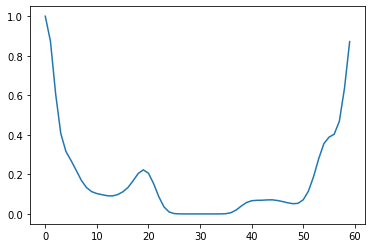

In [24]:
plt.plot(spd_array[8,4,:,0])

SPD for a transition of notes from Ga (20) to Komal Dha (40) to in a descending order

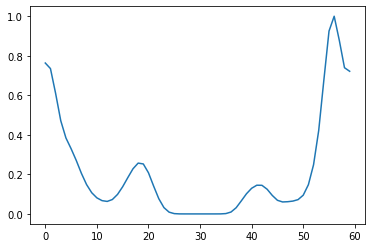

In [25]:
plt.plot(spd_array[8,4,:,1])

### Generates features used for KNN model
See Equation 18, 19; Page 4

Also see lines 270-272, 299-302

In [26]:
def get_knn_features(pitchvalue_prob, spd_array):
    
    hist = get_pitch_histograms(pitchvalue_prob)
    print(hist.shape)
    
    v1 = np.zeros([11,12,60,2])
    for j in range(5,60,5):
        for i in range(0,60,5):
            v1[(j//5)-1,i//5,:,:] = spd_array[i//5,modulo(j+i)//5,:,:]  # Equation 18; Page 4
    
    print(v1.shape)
    
    v2 = np.zeros([12,11,60,2])
    for i in range(0,60,5):
        for j in range(5,60,5):
            v2[i//5,(j//5)-1,:,:] = spd_array[i//5,modulo(j+i)//5,:,:]  # Equation 19; Page 4
    
    print(v2.shape)
    
    return hist, v1, v2
            
    


In [27]:
knn_f = get_knn_features(pitchvalue_prob, spd_array)

(60, 2)
(11, 12, 60, 2)
(12, 11, 60, 2)
